In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

bokuwakira_dataset_path = kagglehub.dataset_download('bokuwakira/dataset')
bokuwakira_new_dataset_path = kagglehub.dataset_download('bokuwakira/new-dataset')
bokuwakira_validdata_path = kagglehub.dataset_download('bokuwakira/validdata')
bokuwakira_dataset2_path = kagglehub.dataset_download('bokuwakira/dataset2')
bokuwakira_finalversion_pytorch_default_1_path = kagglehub.model_download('bokuwakira/finalversion/PyTorch/default/1')

print('Data source import complete.')


100%|██████████| 41.7M/41.7M [00:00<00:00, 88.1MB/s]

Extracting files...


100%|██████████| 303M/303M [00:04<00:00, 73.2MB/s]

Extracting files...


100%|██████████| 32.3M/32.3M [00:00<00:00, 167MB/s]

Extracting files...


100%|██████████| 340M/340M [00:02<00:00, 119MB/s]

Extracting files...



  0%|          | 0.00/6.84M [00:00<?, ?B/s]

  0%|          | 0.00/4.57M [00:00<?, ?B/s]

 22%|██▏       | 1.00M/4.57M [00:00<00:01, 2.80MB/s]
 15%|█▍        | 1.00M/6.84M [00:00<00:02, 2.71MB/s]
 44%|████▍     | 3.00M/6.84M [00:00<00:00, 7.56MB/s]

100%|██████████| 4.57M/4.57M [00:00<00:00, 9.09MB/s]
100%|██████████| 6.84M/6.84M [00:00<00:00, 12.7MB/s]

Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Xử lý dữ liệu training set

In [ ]:

df = pd.read_csv("/kaggle/input/dataset/labeled_train.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/dataset/labeled_train.csv'

In [ ]:
df_train = pd.read_csv("/kaggle/input/dataset2/df_train_with_indicatorsV2.csv")
df_train.head()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

## Xử lý dữ liệu development set

In [ ]:
df_dev2 = pd.read_csv("/kaggle/input/dataset/labeled_dev.csv")

In [ ]:
df_dev = pd.read_csv("/kaggle/input/dataset2/df_dev_with_indicatorsV2.csv")
df_dev.head()

In [ ]:
df_dev.isnull().sum()

In [ ]:
df_dev.shape

# MÔ HÌNH

In [ ]:
df_train.shape

In [ ]:
df

In [ ]:
df_train['Date'] = df['Date']
df_train['Time'] = df['Time']

In [ ]:
df = df_train

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.sort_values('Datetime').reset_index(drop=True)
df['TimeDelta'] = df['Datetime'].diff().dt.total_seconds().div(60).fillna(0)


In [ ]:
df_dev['Date'] = df_dev2['Date']
df_dev['Time'] = df_dev2['Time']

In [ ]:
df_dev['Datetime'] = pd.to_datetime(df_dev['Date'] + ' ' + df_dev['Time'])
df_dev = df_dev.sort_values('Datetime').reset_index(drop=True)
df_dev['TimeDelta'] = df_dev['Datetime'].diff().dt.total_seconds().div(60).fillna(0)


In [ ]:
df.columns

In [ ]:
step = 10
def create_sequences(data, seq_length=60):
    X_seq = []
    for i in range(0,len(data) - seq_length, step):
        seq = data[i:i+seq_length]
        X_seq.append(seq)
    return np.array(X_seq)

In [ ]:
# X_valid_seq = create_sequences(X_valid_scaled, seq_length=60)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch


In [ ]:
BATCH_SIZE = 32

In [ ]:
def create_label_sequences(labels, seq_length=60):
    y_seq = []
    for i in range(0, len(labels) - seq_length, step):
        seq = labels[i + seq_length - 1]
        y_seq.append(seq)
    return np.array(y_seq)


In [ ]:
def create_dataset(step_size, seq_len, batch_size):
    X_seq = create_sequences(X_scaled, seq_len)
    y_seq = create_label_sequences(y, seq_len)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.long)

    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    return train_loader

Thiết kế mô hình Transformers (ver 1)
- Transformer thông thường + Time2Vec
- Tầng Fully Connected sẽ thực hiện tác vụ phân lớp

Với 5 triệu dòng, ta nên chia nhỏ để train mô hình, để sử dụng time2vec thì ta cần 1 tầng linear có size k*2 (số giá trị w và phi)

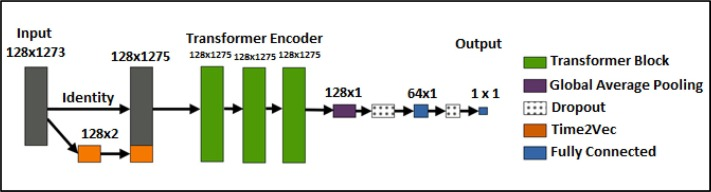

1. Input -> Time2Vec encoding + positional encoding

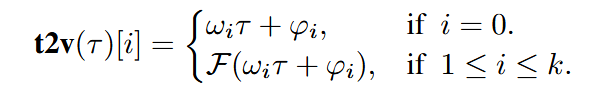

# MODEL V1

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Time2Vec(nn.Module):
  def __init__(self, seq_len, kernel_size):
    super(Time2Vec, self).__init__()
    self.linear = nn.Linear(1,1)      #i = 0
    self.seq_len = seq_len
    self.periodic = nn.Linear(1, kernel_size-1) # i = 1:k
  def forward(self, x):
    seq_len = x.size(1)
    t = torch.arange(seq_len).float().unsqueeze(1).to(x.device)
    lin = self.linear(t)
    sin = torch.sin(self.periodic(t)) # F: sin
    time_embedding = torch.cat([lin, sin], dim=1)  # (seq_len, out_features)
    time_embedding = time_embedding.unsqueeze(0).repeat(x.size(0), 1, 1)  # (batch_size, seq_len, out_features)
    return time_embedding

Các chỉ số đầu vào:
- số lượng đặc trưng: input_dim
- số chiều của time2vec: time2vec_dim
- số chiều của vector biểu diễn cho mỗi bước thời gian: d_model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Định nghĩa lớp Transformer
class Transformer(nn.Module):
    def __init__(self, seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate):
        super(Transformer, self).__init__()
        self.time2vec = Time2Vec(seq_len, time2vec_dim)  # Assumes Time2Vec is defined somewhere else
        self.input_projection = nn.Linear(input_dim + time2vec_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(d_model, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        t2v = self.time2vec(x)  # (batch_size, seq_len, time2vec_dim)
        x = torch.cat([x, t2v], dim=-1)  # (batch_size, seq_len, time2vec_dim + input_dim)
        x = self.input_projection(x)
        x = self.encoder(x)
        x = x.transpose(1, 2)  # (batch_size, total_input_dim, seq_len)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.modules.normalization import LayerNorm  # <--- cái mới bị lỗi

with torch.serialization.safe_globals([
    nn.Linear,
    nn.ModuleList,
    nn.TransformerEncoderLayer,
    nn.TransformerEncoder,
    nn.AdaptiveAvgPool1d,
    nn.Dropout,
    nn.MultiheadAttention,
    NonDynamicallyQuantizableLinear,
    LayerNorm,  # <--- thêm lớp này\
    F.relu,
    Time2Vec,
    Transformer
]):
    model = torch.load('/content/full_model_v1_ach1 (1)', weights_only=True)

model.eval()


Transformer(
  (time2vec): Time2Vec(
    (linear): Linear(in_features=1, out_features=1, bias=True)
    (periodic): Linear(in_features=1, out_features=15, bias=True)
  )
  (input_projection): Linear(in_features=32, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (global_avg_pool): AdaptiveAvgPool1d(output_siz

In [ ]:
labels = df['Label']
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

In [ ]:
def train(model, optimizer, criterion, train_loader, epoch):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for data, labels in train_loader:
        data, labels = data.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    avg_loss = epoch_loss / len(train_loader)
    accuracy = correct / total * 100
    print(f"Epoch [{epoch}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [ ]:
def evaluate(model, criterion, data_loader, epoch):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to('cuda'), labels.to('cuda')
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            epoch_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    avg_loss = epoch_loss / len(data_loader)
    accuracy = correct / total * 100
    print(f"Evaluation [{epoch}] -> Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [ ]:
def test(model, criterion, data_loader):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to('cuda'), labels.to('cuda')
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            epoch_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    avg_loss = epoch_loss / len(data_loader)
    accuracy = correct / total * 100
    print(f"Testing -> Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


Thử với dữ liệu nhỏ trước 250000 dòng

In [ ]:
import torch
import pickle

with open('/content/test_loader.pkl', 'rb') as f:
    test_loader = pickle.load(f)

Thử với chuỗi 128

In [ ]:
seq_len = 128
num_classes = 3
epochs =30
learning_rate = 0.00008
num_layers = 2
input_dim = 16
time2vec_dim = 16
d_model = 128
nhead = 4
dropout_rate = 0.1
model = Transformer(seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

# MODEL V2

Create train loader

In [ ]:
print(valid_size)
print(test_size)

In [ ]:
class Transformer(nn.Module):
  def __init__(self,seq_len,num_classes ,input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate):
    super(Transformer, self).__init__()
    self.time2vec = Time2Vec(seq_len,time2vec_dim)
    self.input_projection1 = nn.Linear(input_dim + time2vec_dim, 32)
    self.input_projection2 = nn.Linear(32, 64)
    self.input_projection3 = nn.Linear(64, d_model)

    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(dropout_rate)
    # self.fc3 = nn.Linear(32, num_classes)
    self.fc1 = nn.Linear(d_model, 32)
    self.fc2 = nn.Linear(32, num_classes)
  def forward(self, x):
    t2v = self.time2vec(x) # (batch_size, seq_len, time2vec_dim)
    x = torch.cat([x, t2v], dim=-1) #(batch_size, seq_len, time2vec_dim + input_dim)
    x = self.input_projection1(x)
    x = self.input_projection2(x)
    x = self.input_projection3(x)
    x = self.encoder(x)
    x = x.transpose(1,2) #(batch_size, total_input_dim, seq_len)
    x = self.global_avg_pool(x).squeeze(-1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    # x = self.dropout(x)
    # x = self.fc3(x)
    return x


In [ ]:
seq_len = 128
num_classes = 3
epochs = 30
learning_rate = 0.00008
num_layers = 3
input_dim = 16
time2vec_dim = 16
d_model = 128
nhead = 4
dropout_rate = 0.1
model = Transformer(seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate=0.1).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

In [ ]:
step_size = 1
seq_len = 128
batch_size = 32

In [ ]:
best_loss =  float('inf')
counter = 0
patience = 10
for epoch in range(1, epochs +1):
    if counter <= patience:
        train(model, optimizer, loss_function, train_loader, epoch)
        avg_loss, _ = evaluate(model,loss_function, valid_loader, epoch)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter +=1

In [ ]:
test(model, loss_function, test_loader)

In [ ]:
def predict(model, loader, device='cuda'):
    model.to(device)
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[0]
            else:
                inputs = batch

            inputs = inputs.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())  # đưa về CPU nếu cần nối nhiều batch

    return torch.cat(all_preds, dim=0)


In [ ]:
model.eval()
device = 'cuda'
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        print("Output:", pred[:10])
        print("Target:", y[:10])
        break

In [ ]:
len(test_loader.dataset)

In [ ]:
import random
from torch.utils.data import Subset, DataLoader

n = 100
start_index = random.randint(0, len(test_loader.dataset) - n)
subset_indices = list(range(start_index, start_index + n))
subset = Subset(test_loader.dataset, subset_indices)
random_test_loader = DataLoader(subset, batch_size=test_loader.batch_size, shuffle=False)

with torch.no_grad():
    for x, y in random_test_loader :
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        print("Output:", pred[:10])
        print("Target:", y[:10])
        break

In [ ]:
seq_len = 128
num_classes = 3
epochs = 30
learning_rate = 0.00005
num_layers = 3
input_dim = 19
time2vec_dim = 2
d_model = 128
nhead = 4
dropout_rate = 0.1
model = Transformer(seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate=0.1).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

In [ ]:
best_loss =  0
counter = 0
patience = 10
for epoch in range(1, epochs +1):
    if counter <= patience:
        train(model, optimizer, loss_function, train_loader, epoch)
        avg_loss, _ = evaluate(model,loss_function, valid_loader, epoch)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter +=1

In [ ]:
torch.save(model, 'full_model_v2')
model = torch.load('full_model_v2')

In [ ]:
seq_len = 128
num_classes = 3
epochs = 30
learning_rate = 0.0001
num_layers = 3
input_dim = 19
time2vec_dim = 2
d_model = 128
nhead = 4
dropout_rate = 0.1
model = Transformer(seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate=0.1).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

In [ ]:
best_loss =  0
counter = 0
patience = 10
for epoch in range(1, epochs +1):
    if counter <= patience:
        train(model, optimizer, loss_function, train_loader, epoch)
        avg_loss, _ = evaluate(model,loss_function, valid_loader, epoch)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter +=1

In [ ]:
torch.save(model, 'full_model_v2_para2')
model = torch.load('full_model_v2_para2')

# MODEL V3

In [ ]:
class Transformer(nn.Module):
  def __init__(self,seq_len,num_classes ,input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate):
    super(Transformer, self).__init__()
    self.time2vec = Time2Vec(seq_len,time2vec_dim)
    self.input_projection1 = nn.Linear(input_dim + time2vec_dim, 64)
    self.input_projection2 = nn.Linear(64, d_model)

    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(dropout_rate)
    # self.fc3 = nn.Linear(32, num_classes)
    self.fc1 = nn.Linear(d_model, 32)
    self.fc2 = nn.Linear(32, num_classes)
  def forward(self, x):
    t2v = self.time2vec(x) # (batch_size, seq_len, time2vec_dim)
    x = torch.cat([x, t2v], dim=-1) #(batch_size, seq_len, time2vec_dim + input_dim)
    x = self.input_projection1(x)
    x = self.input_projection2(x)
    x = self.encoder(x)
    x = x.transpose(1,2) #(batch_size, total_input_dim, seq_len)
    x = self.global_avg_pool(x).squeeze(-1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    # x = self.dropout(x)
    # x = self.fc3(x)
    return x

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
smoothing_window_size = 256
di = 0
end_idx = 0
for di in range(0, X.shape[0], smoothing_window_size):
    end_idx = min(di + smoothing_window_size, X.shape[0])
    scaler.fit(X.iloc[di:end_idx])
    X.iloc[di:end_idx] = pd.DataFrame(
    scaler.transform(X.iloc[di:end_idx]),
    index=X.iloc[di:end_idx].index,
    columns=X.columns
)


In [ ]:
X.iloc[end_idx:X.shape[0]] = pd.DataFrame(
    scaler.transform(X.iloc[di:end_idx]),
    index=X.iloc[di:end_idx].index,
    columns=X.columns
)


In [ ]:
scaler = StandardScaler()
di = 0
end_idx = 0
for di in range(0, X_valid.shape[0], smoothing_window_size):
    end_idx = min(di + smoothing_window_size, X_valid.shape[0])
    scaler.fit(X_valid.iloc[di:end_idx])
    X_valid.iloc[di:end_idx] = pd.DataFrame(
    scaler.transform(X_valid.iloc[di:end_idx]),
    index=X_valid.iloc[di:end_idx].index,
    columns=X_valid.columns
)


In [ ]:
X_valid.iloc[end_idx:X_valid.shape[0]] = pd.DataFrame(
    scaler.transform(X_valid.iloc[di:end_idx]),
    index=X_valid.iloc[di:end_idx].index,
    columns=X_valid.columns
)


In [ ]:
    seq_len = 256
    batch_size = 64
    X_seq = create_sequences(X.values, seq_len)
    y_seq = create_label_sequences(y, seq_len)

    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.long)

    train_dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import random_split
X_seq = create_sequences(X_valid.values, seq_len)
y_seq = create_label_sequences(y_valid, seq_len)

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.long)

valid_dataset = TensorDataset(X_tensor, y_tensor)
valid_size = int(0.8 * len(valid_dataset))
test_size = len(valid_dataset) - valid_size

valid_subset, test_subset = random_split(valid_dataset, [valid_size, test_size])

valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [ ]:
seq_len = 256
num_classes = 3
epochs = 20
learning_rate = 0.00005
num_layers = 3
input_dim = 19
time2vec_dim = 16
d_model = 128
nhead = 4
dropout_rate = 0.1
model = Transformer(seq_len, num_classes, input_dim, time2vec_dim, d_model, nhead, num_layers, dropout_rate=0.1).cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.CrossEntropyLoss()

In [ ]:
best_loss =  0
counter = 0
patience = 10
for epoch in range(1, epochs +1):
    if counter <= patience:
        train(model, optimizer, loss_function, train_loader, epoch)
        avg_loss, _ = evaluate(model,loss_function, valid_loader, epoch)
        if avg_loss < best_loss:
            best_loss = avg_loss
            counter = 0
        else:
            counter +=1